<a href="https://colab.research.google.com/github/shivanibandi110/Sudoku-solver/blob/main/sudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#sudoku_solver_GDSC

In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os
import argparse

In [38]:
#### READ THE MODEL WEIGHTS
def intializePredectionModel():
    model = load_model('/content/drive/MyDrive/Colab Notebooks/myModel.h5')
    return model

In [39]:
#### 1 - Preprocessing Image
def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)  # ADD GAUSSIAN BLUR
    imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)  # APPLY ADAPTIVE THRESHOLD
    return imgThreshold

In [40]:
#### 3 - Reorder points for Warp Perspective
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

In [41]:
#### 3 - FINDING THE BIGGEST COUNTOUR ASSUING THAT IS THE SUDUKO PUZZLE
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

In [42]:
#### 4 - TO SPLIT THE IMAGE INTO 81 DIFFRENT IMAGES
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [43]:
#### 4 - GET PREDECTIONS ON ALL IMAGES
def getPredection(boxes,model):
    result = []
    for image in boxes:
        ## PREPARE IMAGE
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (28, 28))
        img = img / 255
        img = img.reshape(1, 28, 28, 1)
        ## GET PREDICTION
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=-1)
        print(classIndex)
        probabilityValue = np.amax(predictions)
        ## SAVE TO RESULT
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

In [44]:
#### 5 -  TO DISPLAY THE SOLUTION ON THE IMAGE
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img

In [45]:
#### 6 - DRAW GRID TO SEE THE WARP PRESPECTIVE EFFICENCY (OPTIONAL)
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)
    return img

In [46]:
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

In [47]:
def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

In [48]:
def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

In [49]:
def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None

In [53]:
heightImg = 450
widthImg = 450
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", default = 'Resources/1.jpg', help = "path to  input image ")
# args = vars(ap.parse_args())
# model_path = "/content/drive/MyDrive/Colab Notebooks/myModel.h5"
# model = intializePredectionModel(model_path)

model = intializePredectionModel()  # LOAD THE CNN MODEL

In [54]:
#############example solver #########

In [55]:
image_path = "/content/drive/MyDrive/1.jpg"
sudoku_image = cv2.imread(image_path)

In [56]:
# Preprocess the image
processed_image = preProcess(sudoku_image)

In [57]:
# Find the biggest contour
contours, hierarchy = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
biggest_contour, _ = biggestContour(contours)

In [59]:
def warp_perspective(img, biggest_contour):
    width, height = 450, 450
    pts1 = np.float32(biggest_contour)
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    img_output = cv2.warpPerspective(img, matrix, (width, height))
    return img_output


In [61]:
def getPredection(boxes, model):
    result = []
    for image in boxes:
        ## PREPARE IMAGE
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] - 4]
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = img.reshape(28, 28, 1)  # Reshape to match model input shape
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        ## GET PREDICTION
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=-1)
        print(classIndex)
        probabilityValue = np.amax(predictions)
        ## SAVE TO RESULT
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result


In [63]:
def displayNumbers(img, numbers, color=(0, 255, 0)):
    secW = int(img.shape[1] / 9)
    secH = int(img.shape[0] / 9)
    for x in range(9):
        for y in range(9):
            value = numbers[y, x]  # Access value from the numpy array
            if value != 0:  # Check if the value is not zero
                cv2.putText(img, str(value),
                            (x * secW + int(secW / 2) - 10, int((y + 0.8) * secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img


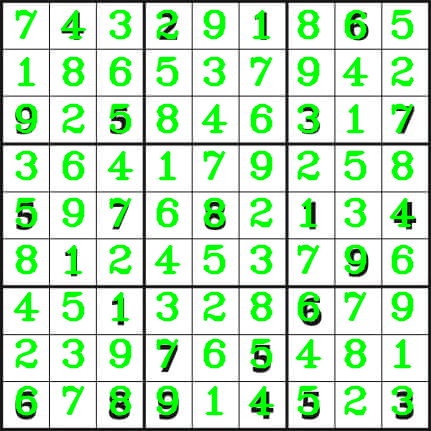

In [65]:
from google.colab.patches import cv2_imshow

# Display the solved image
cv2_imshow(solved_image)


In [66]:
#sudoku-solver completed